# Anomaly detection
This Jupyter Notebook demonstrates the code presented in my blog post: https://adamoudad.github.io/posts/ecg-anomaly-detection/

In [1]:
import pandas as pd
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [2]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocardiogram data
data = raw_data[:, 0:-1]


In [3]:
normal_data = data[labels == 1]
abnormal_data = data[labels == 0]

In [4]:
normal_mean = normal_data.mean(axis=0)
abnormal_mean = abnormal_data.mean(axis=0)

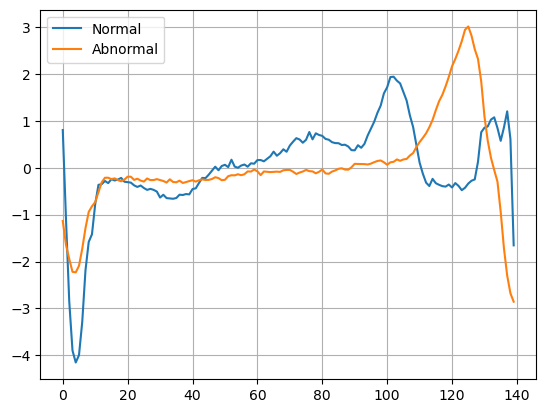

In [10]:
normal_ecg = data[labels == 1][16]
abnormal_ecg = data[labels == 0][5]

import matplotlib.pyplot as plt

plt.grid()
plt.plot(normal_ecg, label="Normal")
plt.plot(abnormal_ecg, label="Abnormal")

plt.legend()
plt.show()

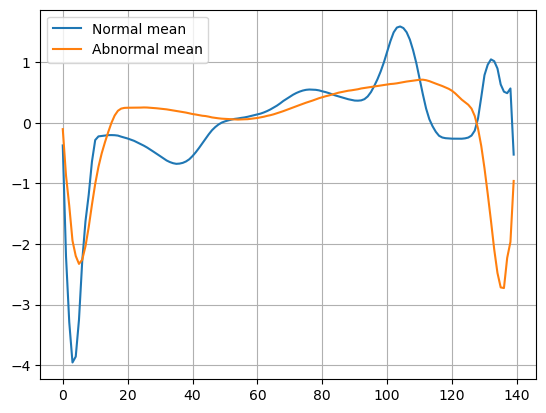

In [12]:
normal_ecg_mean = data[labels == 1].mean(axis=0)
abnormal_ecg_mean = data[labels == 0].mean(axis=0)

import matplotlib.pyplot as plt

plt.grid()
plt.plot(normal_ecg_mean, label="Normal mean")
plt.plot(abnormal_ecg_mean, label="Abnormal mean")

plt.legend()
plt.show()

In [8]:
import random
def train_test_split(data, labels, test_size=0.2, random_state=None):
    split_index = int(len(data) * test_size)
    random.seed(a=random_state)
    random_indices = list(range(len(data)))
    random.shuffle(random_indices)
    shuffled_data = data[random_indices]
    shuffled_labels = labels[random_indices]
    test_data, train_data = shuffled_data[:split_index], shuffled_data[split_index:]
    test_labels, train_labels = shuffled_labels[:split_index], shuffled_labels[split_index:]
    return train_data, test_data, train_labels, test_labels

In [9]:
import torch
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

# Normalize the data
min_val = train_data.min()
max_val = train_data.max()

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = torch.tensor(train_data, dtype=float)
test_data = torch.tensor(test_data, dtype=float)

train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

In [13]:
class AnomalyDetector(torch.nn.Module):
    def __init__(self, input_size=140):
        super(AnomalyDetector, self).__init__()
        self.enc1 = torch.nn.Linear(input_size, 32)
        self.enc2 = torch.nn.Linear(32, 16)
        self.enc3 = torch.nn.Linear(16, 8)

        self.relu = torch.nn.functional.relu
        self.sigmoid = torch.sigmoid

        self.dec1 = torch.nn.Linear(8, 16)
        self.dec2 = torch.nn.Linear(16, 32)
        self.dec3 = torch.nn.Linear(32, input_size)

    def encoder(self, x):
        outputs = self.enc1(x)
        outputs = self.relu(outputs)
        outputs = self.enc2(outputs)
        outputs = self.relu(outputs)
        outputs = self.enc3(outputs)
        outputs = self.relu(outputs)
        return outputs
    
    def decoder(self, x):
        outputs = self.dec1(x)
        outputs = self.relu(outputs)
        outputs = self.dec2(outputs)
        outputs = self.relu(outputs)
        outputs = self.dec3(outputs)
        outputs = self.sigmoid(outputs)
        return outputs
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
autoencoder = AnomalyDetector()
optimizer = torch.optim.Adam(autoencoder.parameters())
criterion = torch.nn.L1Loss()

In [14]:
from tqdm import trange
batch_size = 32

epochs = 100
losses = []
test_losses = []

autoencoder = autoencoder.train()

n_batches = len(normal_train_data) // batch_size

with trange(epochs) as tbar:
    for epoch in tbar:
        epoch_loss = 0.
        for i in range(0, len(normal_train_data), batch_size):
            batch = normal_train_data[i:i+batch_size]
            optimizer.zero_grad()
            outputs = autoencoder(batch.float())
            loss = criterion(outputs, batch.float())
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_loss /= float(n_batches)
        losses.append(epoch_loss)
        with torch.no_grad():
            outputs = autoencoder(test_data.float())
            loss = criterion(outputs, test_data.float())
            test_loss = loss.item()
            test_losses.append(test_loss)
        tbar.set_postfix(loss=epoch_loss, test=test_loss)

100%|██████████████████████████████████████████| 100/100 [00:07<00:00, 12.71it/s, loss=0.0106, test=0.021]


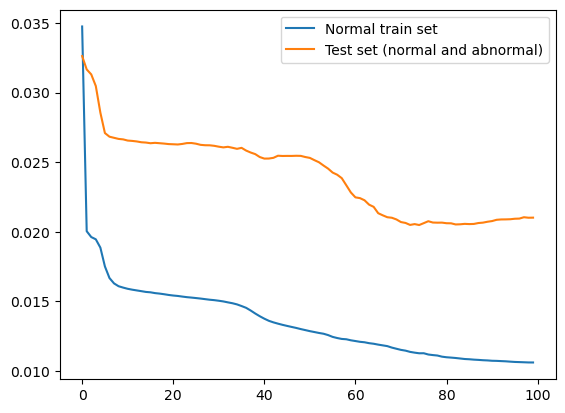

In [15]:
import matplotlib.pyplot
plt.plot(losses, label="Normal train set")
plt.plot(test_losses, label="Test set (normal and abnormal)")
plt.legend()

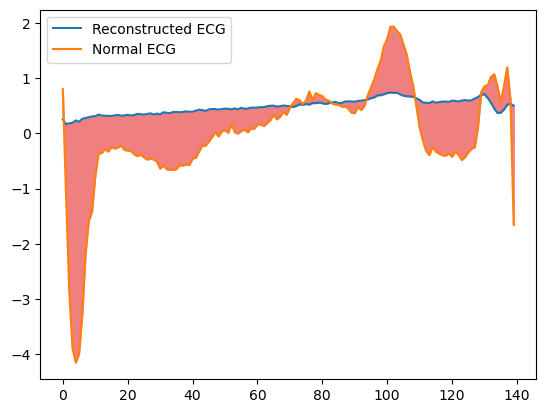

In [16]:
normal_ecg = data[labels == 1][16]

with torch.no_grad():
    x = torch.tensor(normal_ecg).float().unsqueeze(0)
    reconstructed_ecg = autoencoder(x).squeeze()

import numpy as np
plt.plot(reconstructed_ecg, label="Reconstructed ECG")
plt.plot(normal_ecg, label="Normal ECG")
plt.fill_between(np.arange(140), reconstructed_ecg, normal_ecg, color='lightcoral')
plt.legend()

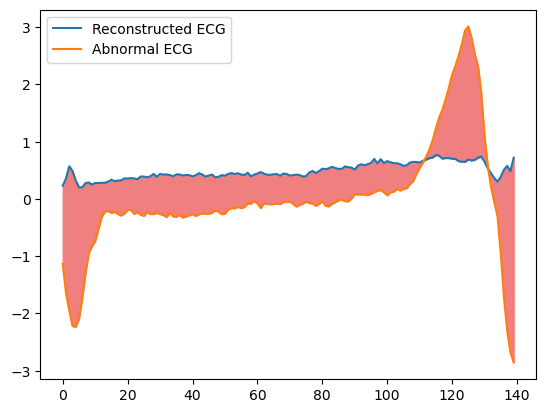

In [17]:
abnormal_ecg = data[labels == 0][5]

with torch.no_grad():
    x = torch.tensor(abnormal_ecg).float().unsqueeze(0)
    reconstructed_ecg = autoencoder(x).squeeze()

import numpy as np
plt.plot(reconstructed_ecg, label="Reconstructed ECG")
plt.plot(abnormal_ecg, label="Abnormal ECG")
plt.fill_between(np.arange(140), reconstructed_ecg, abnormal_ecg, color='lightcoral')
plt.legend()

In [19]:
normal_train_data.float()

tensor([[0.5459, 0.4313, 0.2714,  ..., 0.5714, 0.5905, 0.5384],
        [0.5554, 0.4878, 0.3706,  ..., 0.5494, 0.5103, 0.4871],
        [0.4061, 0.2728, 0.2028,  ..., 0.5123, 0.4896, 0.4716],
        ...,
        [0.4398, 0.2796, 0.2387,  ..., 0.5166, 0.5706, 0.4429],
        [0.3419, 0.1657, 0.1840,  ..., 0.4726, 0.5339, 0.5064],
        [0.3824, 0.2777, 0.2560,  ..., 0.5157, 0.5230, 0.4717]])

/run/user/1000/ipykernel_81455/2269535928.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reconstructions = autoencoder(torch.tensor(normal_test_data).float())
/run/user/1000/ipykernel_81455/2269535928.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loss = (torch.tensor(normal_test_data).float() - reconstructions).abs().mean(dim=-1)


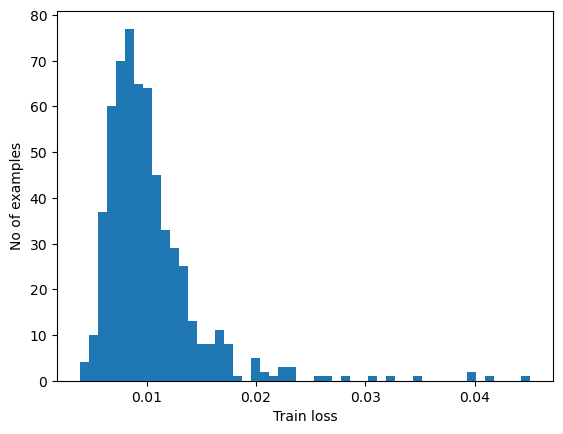

In [44]:
with torch.no_grad():
    reconstructions = autoencoder(torch.tensor(normal_test_data).float())
    train_loss = (torch.tensor(normal_test_data).float() - reconstructions).abs().mean(dim=-1)
train_loss = train_loss.numpy()

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

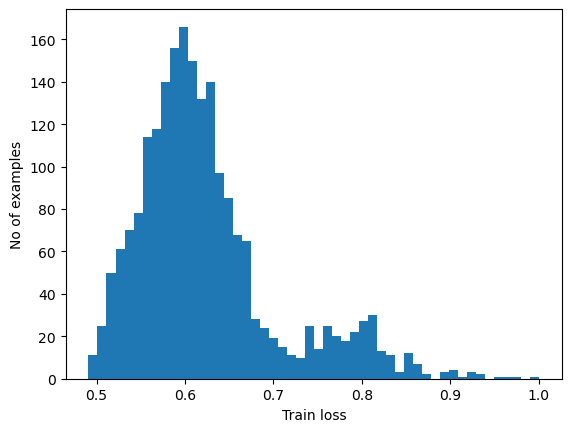

In [41]:
with torch.no_grad():
    reconstructions = autoencoder(torch.tensor(abnormal_data).float())
train_loss = (torch.tensor(abnormal_data).float() - reconstructions).abs().mean(dim=-1).numpy()

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

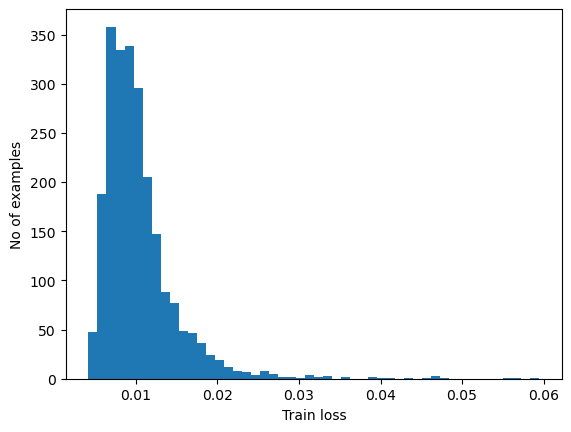

In [38]:
with torch.no_grad():
    reconstructions = autoencoder(normal_train_data.float())
train_loss = (normal_train_data.float() - reconstructions).abs().mean(dim=-1).numpy()

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [45]:
test_data

tensor([[0.3902, 0.2445, 0.2194,  ..., 0.5718, 0.5727, 0.4173],
        [0.5321, 0.4059, 0.2560,  ..., 0.5809, 0.5893, 0.4928],
        [0.2322, 0.1977, 0.1789,  ..., 0.5156, 0.5299, 0.4990],
        ...,
        [0.4387, 0.2897, 0.1960,  ..., 0.5721, 0.6167, 0.5444],
        [0.3548, 0.2209, 0.1847,  ..., 0.5175, 0.5233, 0.3739],
        [0.4098, 0.2453, 0.1584,  ..., 0.5237, 0.5042, 0.5162]],
       dtype=torch.float64)

In [61]:
# def print_stats(predictions, labels):
#   print("Accuracy = {}".format(accuracy_score(labels, predictions)))
#   print("Precision = {}".format(precision_score(labels, predictions)))
#   print("Recall = {}".format(recall_score(labels, predictions)))

threshold = 0.02
with torch.no_grad():
    outputs = autoencoder(test_data.float())
mae = (test_data.float() - outputs).abs().mean(dim=-1)
preds = mae < threshold
tp = 

score = (preds == torch.tensor(test_labels).bool())

In [68]:
score.float().mean()

tensor(0.9670)